In [297]:
import pickle 
import numpy as np 
import pickle
import numpy as np
import pandas as pd
from scipy import interpolate, integrate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm 

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

In [ ]:
PERSONAL_DATA_DIR = '/home/kitadam/ENR_Sven/moxie_revisited/data/raw/'
PERSONAL_DATA_DIR_PROC = '/home/kitadam/ENR_Sven/moxie_revisited/data/processed/'
JET_RAW_FILE_LOC = PERSONAL_DATA_DIR + 'JET_pdb_pulses_raw_data.pickle'
JET_PDB_FILE_LOC = PERSONAL_DATA_DIR + 'jet-pedestal-database.csv'

# with open(JET_RAW_FILE_LOC, 'rb') as file: 
#     JET_RAW_DICT = pickle.load(file)

JET_PDB = pd.read_csv(JET_PDB_FILE_LOC) 

PULSE_DF = JET_PDB[JET_PDB['FLAG:HRTSdatavalidated'] > 0]
PULSE_LIST = PULSE_DF['shot'].to_list()
# PULSE_LIST =  [int(x) for x in PULSE_LIST]

AUG_RAW_FILE_LOC = PERSONAL_DATA_DIR + 'AUG_pdb_pulses_raw_data.pickle'
AUG_PDB_FILE_LOC = PERSONAL_DATA_DIR + 'AUG_PEDDB_20210422.dat'



with open(PERSONAL_DATA_DIR_PROC + 'pedestal_profiles_ML_READY_ak_09022022.pickle', 'rb') as file:
    big_dict = pickle.load(file)

### Important params 

- Keys for padded/raw datasets: 
    - `['profiles', 'controls', 'profiles_uncert', 'radii', 'stored_energy', 'pulse_time_ids', 'masks', 'vjacs', 'alpha_psi1']`
- Order of control parameters (this probably should have been stored but oh well 
    - `['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']`


In [10]:
all_dict, train_dict, val_dict, test_dict = big_dict.values()
MP_NAME_LIST = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
JETPDB_NAME_LIST = ['q95', 'R(m)', 'a(m)', 'plasmavolume(m^3)','averagetriangularity','averagetriangularity', 'averagetriangularity', 'averagetriangularity','Ip(MA)', 'B(T)',  'P_NBI(MW)','P_ICRH(MW)', 'gasflowrateofmainspecies10^22(e/s)']

What follows is a bunch of plotting scripts

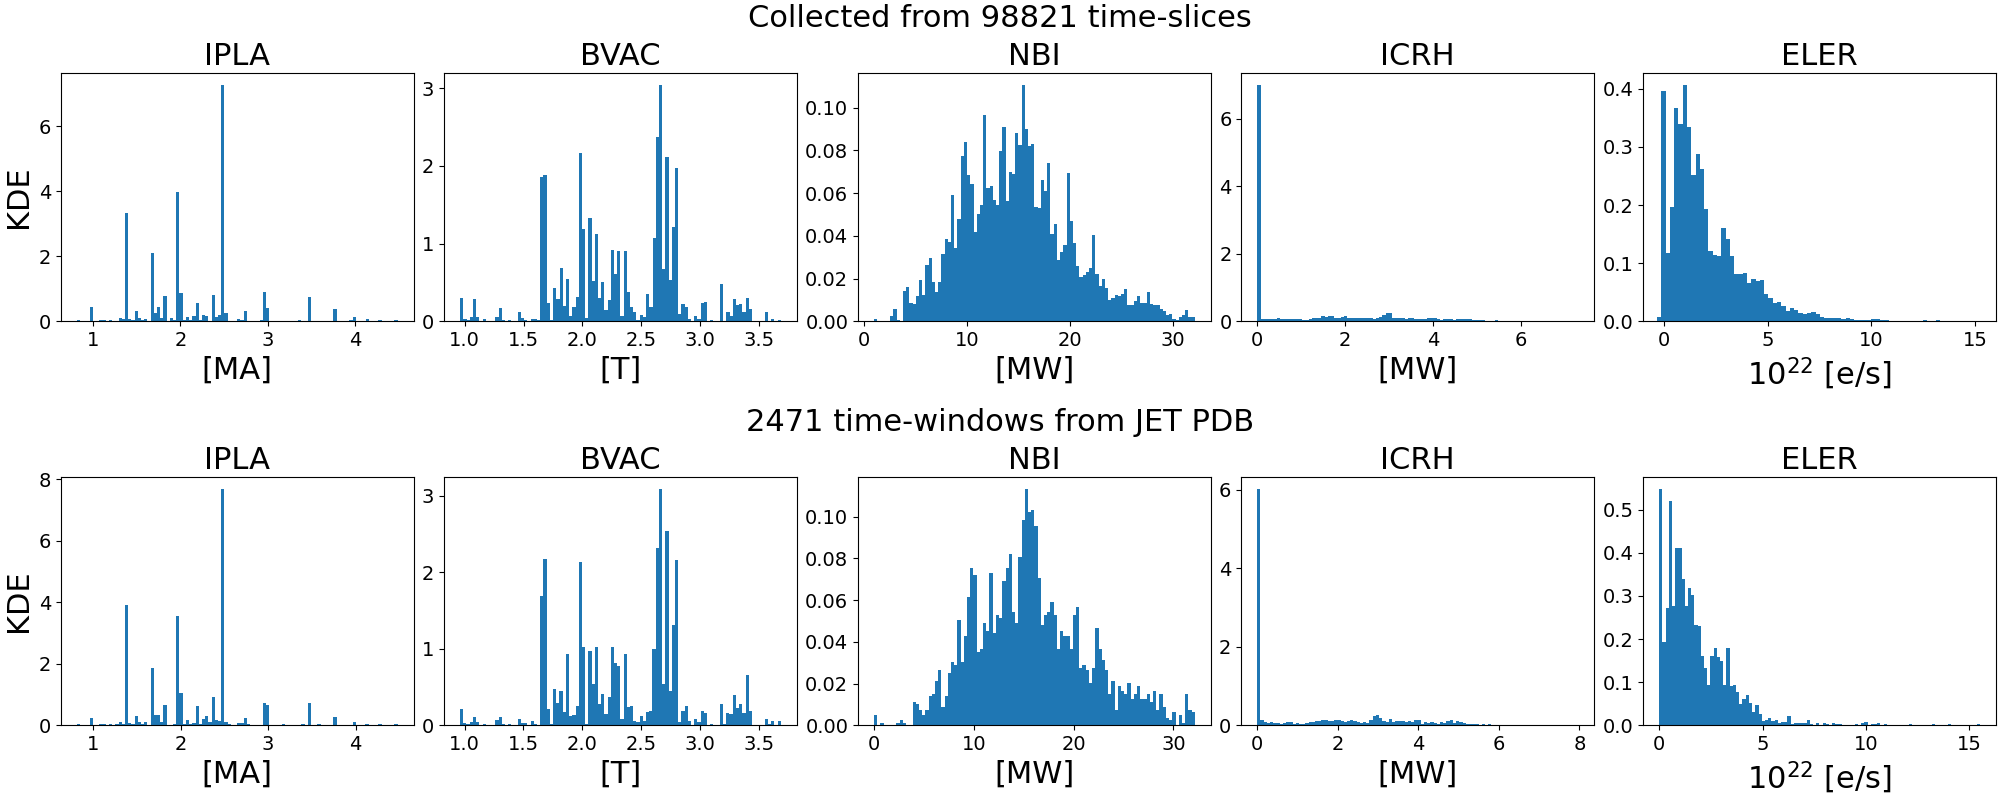

In [300]:
all_profs, all_radii, all_controls, all_ids, all_masks = all_dict['padded']['profiles'], all_dict['padded']['radii'], all_dict['padded']['controls'], all_dict['padded']['pulse_time_ids'], all_dict['padded']['masks']
# comparison_dict = {'Raw Current': np.zeros(len(all_controls)), 'Raw Q95': np.zeros(len(all_controls))}

plt.close()

fig = plt.figure(constrained_layout=True, figsize=(20, 8)) 

subfigs = fig.subfigures(nrows=2, ncols=1)

for row, (subfig, label) in enumerate(zip(subfigs, ['Collected from {} time-slices'.format(len(all_profs)), '{} time-windows from JET PDB'.format(len(PULSE_DF))])): 
    subfig.suptitle(label)
    
    # cols_to_plot = [0,1,2,3,4]
    # units = ['-', '[m]', '[m]', r'[m$^3$]', '[-]']
    cols_to_plot = [8, 9, 10, 11, 12]
    units = ['[MA]', '[T]', '[MW]', '[MW]', '$10^{22}$ [e/s]']
    # cols_to_plot = [0, 1, 2, 3, 8, 9, 10, 11, 12]
    # units = ['-', '[m]', '[m]', r'[m$^3$]', '[MA]', '[T]', '[MW]', '[MW]', '[e/s]']
    axs = subfig.subplots(nrows=1, ncols=len(cols_to_plot))
    for col, (ax, tup) in enumerate(zip(axs, cols_to_plot)): 
        ax.set_title(MP_NAME_LIST[tup])
        if label != '{} time-windows from JET PDB'.format(len(PULSE_DF)): 
            if tup == 4: 
                ax.hist(np.mean(all_controls[:, 4:6], 1), bins=100, density=True)
            elif tup == 8: 
                ax.hist(-all_controls[:, tup]*1e-6, bins=100, density=True)
            elif tup == 9: 
                ax.hist(-all_controls[:, tup], bins=100, density=True)
            elif tup == 10 or tup == 11: 
                ax.hist(all_controls[:, tup]*1e-6, bins=100, density=True)
            elif tup == 12: 
                ax.hist(all_controls[:, tup]*1e-22, bins=100, density=True)
                ax.set_xlim(-1, 16)
            else: 
                ax.hist(all_controls[:, tup], bins=100, density=True)
        else: 
            ax.hist(PULSE_DF[JETPDB_NAME_LIST[tup]], bins=100, density=True)
        if tup == 4: 
            ax.set_title('TRI_AVG') 
        if tup == 2: 
            ax.set_title('a(CR0)') 
        ax.set_xlabel(units[col])
        if col == 0: 
            ax.set_ylabel('KDE')
        
                
            
plt.show()

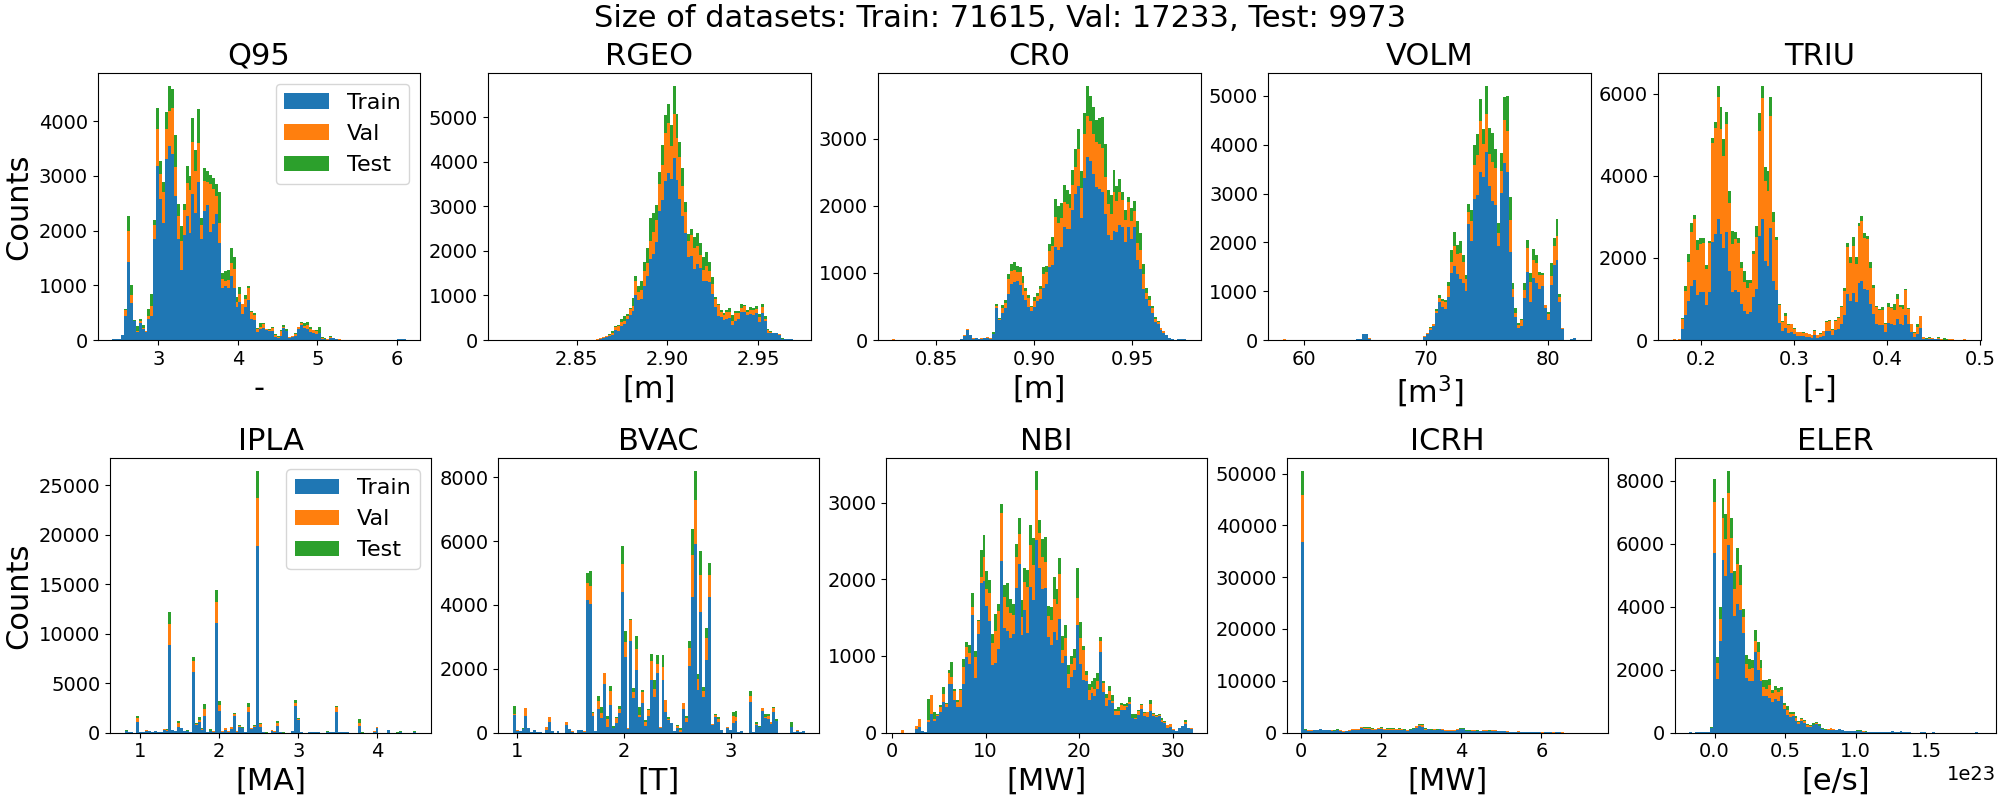

In [302]:
train_profs, train_radii, train_controls, train_ids, train_masks = train_dict['padded']['profiles'], train_dict['padded']['radii'], train_dict['padded']['controls'], train_dict['padded']['pulse_time_ids'], train_dict['padded']['masks']
val_profs, val_radii, val_controls, val_ids, val_masks = val_dict['padded']['profiles'], val_dict['padded']['radii'], val_dict['padded']['controls'], val_dict['padded']['pulse_time_ids'], val_dict['padded']['masks']
test_profs, test_radii, test_controls, test_ids, test_masks = test_dict['padded']['profiles'], test_dict['padded']['radii'], test_dict['padded']['controls'], test_dict['padded']['pulse_time_ids'], test_dict['padded']['masks']

plt.close()

fig = plt.figure(constrained_layout=True, figsize=(20, 8)) 
fig.suptitle('Size of datasets: Train: {}, Val: {}, Test: {}'.format(len(train_profs), len(val_profs), len(test_profs)))

subfigs = fig.subfigures(nrows=2, ncols=1)

subfig = subfigs[0]

cols_to_plot = [0,1,2,3,4]
units = ['-', '[m]', '[m]', r'[m$^3$]', '[-]']
axs = subfig.subplots(nrows=1, ncols=len(cols_to_plot))

for col, (ax, tup) in enumerate(zip(axs, cols_to_plot)): 
    ax.set_title(MP_NAME_LIST[tup])
    if tup == 4: 
        list_splits = [np.mean(train_controls[:, 4:6], 1), np.mean(train_controls[:, 4:6], 1), np.mean(test_controls[:, 4:6], 1)]
    else: 
        list_splits = [train_controls[:, tup], val_controls[:, tup], test_controls[:, tup]]
    
    ax.hist(list_splits, bins=100, stacked=False,histtype='barstacked',  label=['Train', 'Val', 'Test'])
    ax.set_xlabel(units[col])
    if col == 0: 
        ax.set_ylabel('Counts')
        ax.legend()

subfig = subfigs[1]


cols_to_plot = [8,9,10,11,12]
units = ['[MA]', '[T]', '[MW]', '[MW]', '[e/s]']
axs = subfig.subplots(nrows=1, ncols=len(cols_to_plot))

for col, (ax, tup) in enumerate(zip(axs, cols_to_plot)): 
    ax.set_title(MP_NAME_LIST[tup])
    if tup == 8: 
        list_splits = [-train_controls[:, tup]*1e-6, -val_controls[:, tup]*1e-6, -test_controls[:, tup]*1e-6]
    elif tup == 9: 
        list_splits = [-train_controls[:, tup], -val_controls[:, tup], -test_controls[:, tup]]
    elif tup == 10 or tup == 11: 
        list_splits = [train_controls[:, tup]*1e-6, val_controls[:, tup]*1e-6, test_controls[:, tup]*1e-6]
    else: 
        list_splits = [train_controls[:, tup], val_controls[:, tup], test_controls[:, tup]]
    
    ax.hist(list_splits, bins=100, stacked=False,histtype='barstacked',  label=['Train', 'Val', 'Test'])
    ax.set_xlabel(units[col])
    if col == 0: 
        ax.set_ylabel('Counts')
        ax.legend()


plt.show()    


In [197]:
# check profiles 
all_profs, all_radii, all_controls, all_ids, all_masks = all_dict['padded']['profiles'], all_dict['padded']['radii'], all_dict['padded']['controls'], all_dict['padded']['pulse_time_ids'], all_dict['padded']['masks'] < 1
train_profs, train_radii, train_controls, train_ids, train_masks = train_dict['padded']['profiles'], train_dict['padded']['radii'], train_dict['padded']['controls'], train_dict['padded']['pulse_time_ids'], train_dict['padded']['masks'] < 1
val_profs, val_radii, val_controls, val_ids, val_masks = val_dict['padded']['profiles'], val_dict['padded']['radii'], val_dict['padded']['controls'], val_dict['padded']['pulse_time_ids'], val_dict['padded']['masks'] < 1
test_profs, test_radii, test_controls, test_ids, test_masks = test_dict['padded']['profiles'], test_dict['padded']['radii'], test_dict['padded']['controls'], test_dict['padded']['pulse_time_ids'], test_dict['padded']['masks'] < 1

all_heights = []
all_neseps = []
all_sep_psi = []

for profs, masks, radii, ids, set_name in zip([train_profs, val_profs, test_profs], [train_masks, val_masks, test_masks],[train_radii, val_radii, test_radii],  [train_ids, val_ids, test_ids], ['train', 'val', 'test']): 
    densities = np.ma.MaskedArray(data = profs[:, 0, :], mask=masks)
    temperatures = np.ma.MaskedArray(data = profs[:, 1, :], mask=masks)
    print(set_name)
    plt.close()
    
    
    pedestal_heights = []
    pedestal_heights_psi = []
    sep_ne = []
    sep_psi = []
    
    
    for dens, temp, radius, pulse_id in zip(densities, temperatures, radii, ids): 
        pulse_num, pulse_t = pulse_id.split('/')
        
        dens_m = dens.compressed()
        temp_m = temp.compressed()
        
        closest = row.iloc[0]
        if len(row) > 1: 
            closest = row.iloc[(row['t1']-float(pulse_t)).abs().argsort()[:2]].iloc[0]
        
        rad = radius[np.invert(dens.mask)]
        ped_mask = rad > 0.88
        diff = len(rad) - ped_mask.sum()
        
        ped_height_psi, ped_height = rad[np.argmax(dens_m[ped_mask]) + diff], np.max(dens_m[ped_mask])
        pedestal_heights.append(ped_height)
        pedestal_heights_psi.append(ped_height_psi)

        tsep_100_mask = np.logical_and(temp_m > 0.1, temp_m<500)
        l = 10
        while len(temp_m[tsep_100_mask]) < 2:
            tsep_100_mask = np.logical_and(temp_m > 0.1, temp_m<500+l)
            l += 10

        tsep_100 = np.mean(temp_m[tsep_100_mask])
        nesep_t100 = np.mean(dens_m[tsep_100_mask])
        psi_t100 = np.mean(rad[tsep_100_mask])
        
        
        sep_ne.append(nesep_t100)
        sep_psi.append(psi_t100)
        # plt.scatter(rad, dens_m, c='forestgreen', zorder=0)        
        # plt.scatter(ped_height_psi, ped_height, c='salmon', zorder=10)
        # plt.scatter(psi_t100, nesep_t100, c='orange', zorder=10)
        
    
    all_heights.append(pedestal_heights)
    all_neseps.append(sep_ne)
    all_sep_psi.append(sep_psi)
    # plt.hist(pedestal_heights)
    # plt.show()
            
    

# train_profs[:, 0, :]


train
val
test


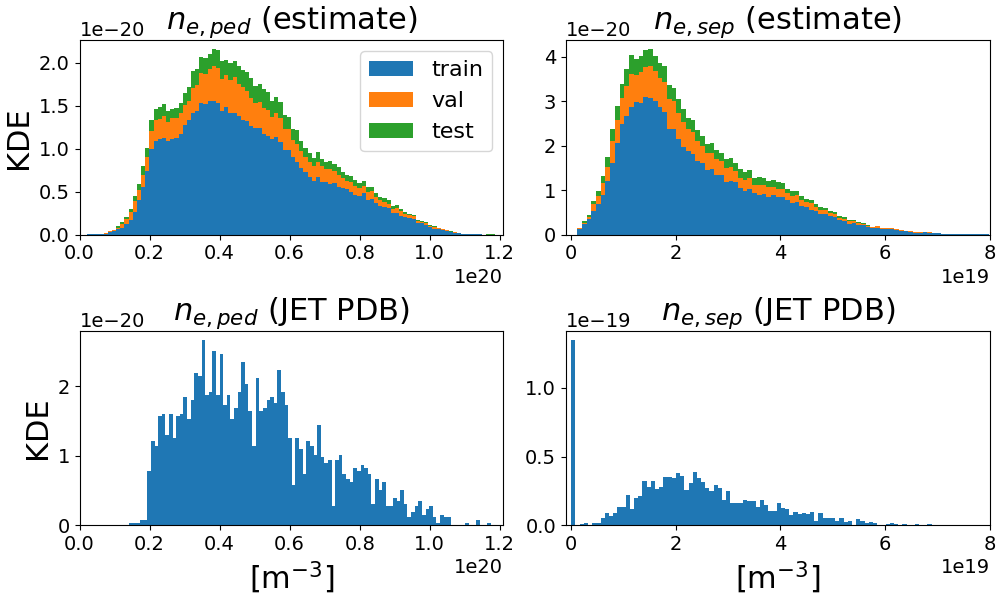

In [313]:
plt.close()
fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True) 

axs = axs.ravel()
axs[0].hist(all_heights, label=['train', 'val', 'test'], histtype='barstacked',bins=100,density=True, )
axs[1].hist(all_neseps, label=['train', 'val', 'test'], histtype='barstacked',density=True, bins=100)

axs[2].hist(PULSE_DF['nepedheight10^19(m^-3)']*1e19,density=True,  bins=100)
axs[3].hist(PULSE_DF['neseparatrixfromfit10^19(m^-3)']*1e19,density=True, bins=100)

axs[0].legend()
axs[0].set_title('$n_{e, ped}$ (estimate)') 
axs[2].set_title('$n_{e, ped}$ (JET PDB)')
axs[1].set_title('$n_{e, sep}$ (estimate)')
axs[3].set_title('$n_{e, sep}$ (JET PDB)')

axs[2].set_xlabel('[m$^{-3}$]')
axs[3].set_xlabel('[m$^{-3}$]')
axs[0].set_xlim(0, 1.21e20)
axs[2].set_xlim(0, 1.21e20)

axs[1].set_xlim(-1e18, 8e19)
axs[3].set_xlim(-1e18, 8e19)
axs[0].set_ylabel('KDE')
axs[2].set_ylabel('KDE')

plt.savefig('/home/kitadam/ENR_Sven/moxie_revisited/docs/source/dataset/neped-nesep-rough-calc-compare-jetpdb.png', bbox_inches='tight')
plt.show()

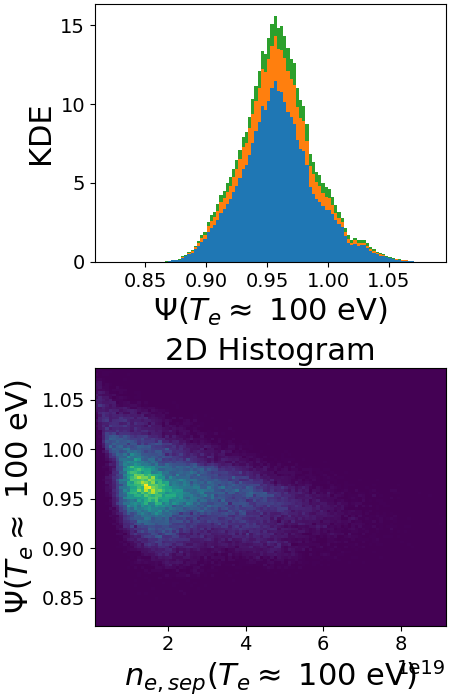

In [314]:
plt.close()
fig, axs = plt.subplots(2, 1, figsize=(4.5, 7), constrained_layout=True)

axs[0].hist(all_sep_psi, histtype='barstacked',label=['train', 'val', 'test'], bins=100, density=True)
axs[0].set_xlabel(r'$\Psi (T_e \approx$ 100 eV)')

axs[0].set_ylabel('KDE')

axs[1].hist2d(all_neseps[0], all_sep_psi[0], bins=100, density=True)
axs[1].set_ylabel(r'$\Psi (T_e \approx$ 100 eV)')
axs[1].set_xlabel(r'$n_{e, sep} (T_e \approx$ 100 eV)')
axs[1].set_title('2D Histogram')
plt.savefig('/home/kitadam/ENR_Sven/moxie_revisited/docs/source/dataset/sep_vs_psi_both.png', bbox_inches='tight')
plt.show()


In [273]:
all_profs, all_radii, all_controls, all_ids, all_masks = all_dict['padded']['profiles'], all_dict['padded']['radii'], all_dict['padded']['controls'], all_dict['padded']['pulse_time_ids'], all_dict['padded']['masks'] < 1
train_profs, train_radii, train_controls, train_ids, train_masks = train_dict['padded']['profiles'], train_dict['padded']['radii'], train_dict['padded']['controls'], train_dict['padded']['pulse_time_ids'], train_dict['padded']['masks'] < 1
val_profs, val_radii, val_controls, val_ids, val_masks = val_dict['padded']['profiles'], val_dict['padded']['radii'], val_dict['padded']['controls'], val_dict['padded']['pulse_time_ids'], val_dict['padded']['masks'] < 1
test_profs, test_radii, test_controls, test_ids, test_masks = test_dict['padded']['profiles'], test_dict['padded']['radii'], test_dict['padded']['controls'], test_dict['padded']['pulse_time_ids'], test_dict['padded']['masks'] < 1

all_heights_ne = []
all_heights_te = []
all_currents = []

for profs, masks, controls, radii, ids, set_name in zip([train_profs, val_profs, test_profs], [train_masks, val_masks, test_masks], [train_controls, val_controls, test_controls], [train_radii, val_radii, test_radii],  [train_ids, val_ids, test_ids], ['train', 'val', 'test']): 
    densities = np.ma.MaskedArray(data = profs[:, 0, :], mask=masks)
    temperatures = np.ma.MaskedArray(data = profs[:, 1, :], mask=masks)
    plt.close()
    
    
    pedestal_heights_ne, pedestal_heights_te, currents  = [], [], []
    
    for dens, temp, radius, pulse_id, control in zip(densities, temperatures, radii, ids, controls): 
        pulse_num, pulse_t = pulse_id.split('/')
        
        dens_m = dens.compressed()
        temp_m = temp.compressed()
        
        rad = radius[np.invert(dens.mask)]
        ped_mask = np.logical_and(rad > 0.88, rad < 0.95)
        # diff = len(rad) - ped_mask.sum()
        location_of_ped = np.where((np.gradient(dens_m) < 0) == True)[0][0]
        if location_of_ped == 0: 
            ped_height_ne, ped_height_te = np.mean(dens_m[location_of_ped:location_of_ped+2]), np.mean(temp_m[location_of_ped:location_of_ped+2])
        else: 
            ped_height_ne, ped_height_te = np.max(dens_m[location_of_ped-1:location_of_ped+1]), np.mean(temp_m[location_of_ped-1:location_of_ped+1])
        pedestal_heights_ne.append(ped_height_ne)
        pedestal_heights_te.append(ped_height_te)
        currents.append(-control[8])
        
    all_heights_ne.append(pedestal_heights_ne)
    all_heights_te.append(pedestal_heights_te)
    all_currents.append(currents)

train
val
test


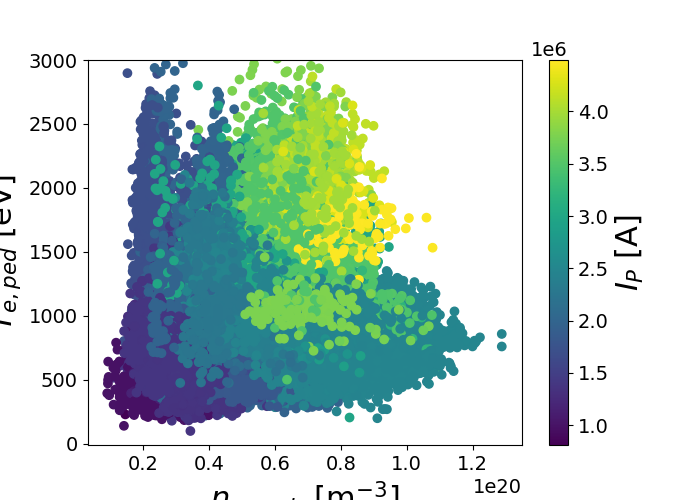

In [312]:
plt.close()

fig = plt.figure(figsize=(7, 5))

plot1 = plt.scatter(all_heights_ne[0], all_heights_te[0], c=all_currents[0])
plt.ylim(-10, 3000)
plt.colorbar(plot1, label='$I_P$ [A]')
plt.xlabel('$n_{e, ped}$, [m$^{-3}$]')
plt.ylabel('$T_{e, ped}$ [eV]')
plt.savefig('/home/kitadam/ENR_Sven/moxie_revisited/docs/source/dataset/Current_VS_NEPED_TEPED.png', bbox_inches='tight')
plt.show()

In [287]:
len(set(PULSE_DF['shot']))

1859